### Deep Self-Organizing Map (DeepSOM)

L'objectif de ce TP est de créer et manipuler un Deep Self-Organizing Map (DeepSOM) afin d'apprendre une nouvelle représentation des données qui met en valeur leurs similarités.


###### 1. Importation des librairies 

In [161]:
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn import datasets    
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

###### 2. Classe décrivant l'initialisation et l'apprentissage d'une SOM probabiliste

Lisez attentivement ce code et vérifiez que vous ayez bien compris les différentes étapes de l'initialisation et de l'apprentissage.

In [158]:
class PrSOM: # Une couche de SOM probabiliste
    def __init__(self, data, shape):
        self.shape = shape
        self.N, self.dim = data.shape
        self.data = data
     
        # Initialisation des prototypes selon les axes de l'ACP
        self.pca = PCA().fit(self.data) 
        var = self.pca.transform(data).std(axis = 0)[0:2]
        rangex = np.arange(-var[0],var[0],var[0]*2/self.shape[0])
        if len(rangex)>self.shape[0]:
            rangex = rangex[:-1]
        rangey = np.arange(-var[1],var[1],var[1]*2/self.shape[1])
        if len(rangey)>self.shape[1]:
            rangey = rangey[:-1]  
        self.W = []
        for x in rangex:
            for y in rangey:
                self.W.append([x,y])
                
        self.W = np.hstack((np.array(self.W), np.zeros((len(self.W),self.dim-2))))
        self.W =self.pca.inverse_transform(self.W[:,:self.pca.components_.shape[0]])
        if np.sum(self.data) == self.N:
            self.W[self.W<0]=0
        
        # Initialization des temperatures (radius de voisinage)
        self.s0 = max(1,max(self.shape)/4)
        self.sf = 1
        self.s = self.s0

        # Initialization de beta
        d = self.dist(self.W,self.W)
        d[d==0] = 'NaN'
        self.beta = 1/(np.max(np.nanmin(d,axis=0))**2)

        # Nombre de neurones
        self.nb_neuron = int(np.product(self.shape))        
        
        # Coordonnée des neurones
        self.coord = []
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                self.coord.append([(i,j)])
        
        # Distance euclidienne entre les prototypes de la première couche
        self.distmat = np.zeros((self.nb_neuron, self.nb_neuron))      
        for n in range(self.nb_neuron):
            for m in range(self.nb_neuron):
                self.distmat[n,m] = euclidean(self.coord[n],self.coord[m])

        # Initialization de la matrice P de probabilité entre chaque donnée et chaque neurone
        self.P = np.zeros((self.N, self.nb_neuron))+1/self.nb_neuron
        
        # Initialization de la matrice q de probabilité à priori pour chaque neurone
        self.q = np.zeros(self.nb_neuron)+1/self.nb_neuron
        
     
    def Kij(self, T): # Calcul de la fonction de voisinage
        self.s = self.s0*(self.sf/self.s0)**(T/self.Tmax)
        if self.s>0:
            return np.exp(-self.distmat**2/(2*self.s**2))
        else:
            return np.identity(self.nb_neuron)
        
        
    def train(self,Tmax): #Apprentissage
        self.Tmax = Tmax
        
        for T in range(Tmax):
            # Calcul de K, la fonction de voisinage
            self.K = self.Kij(T)
            
            # Affectation des données aux neurones (calcul de P)
            self.assign(self.data)
            
            # Mise à jours de prototypes (calcul de W)
            self.update()
            
            

    
    def dist(self, X1, X2):  # Calcul des distances 
        if np.sum(self.data) == self.N:
            return 1/np.sqrt(2)*euclidean_distances(np.sqrt(X1), np.sqrt(X2)) ## Hellinger pour probabilités
        else:
            return euclidean_distances(X1, X2)  ## Euclidienne pour vecteurs (première couche)
            
        
    def assign(self, X):  ## Calcul de la matrice P de probabilité entre chaque donnée et chaque neurone 
        # Distance entre les données et les prototypes
        self.Dxw = 1/2*self.dist(X, self.W)**2 
        
        # Création de la matrice Q
        Q = np.tile(self.q,(self.N,1)).T 
        
        # Calcul de P
        self.P = Q * np.dot(self.K,np.exp(-self.beta*self.Dxw.T)) 
        norm = np.tile(np.sum(self.P, axis=0),(self.nb_neuron,1))+1e-16
        self.P = self.P / norm       
        
        return self.P


    def update(self): ## Calcul de W, la matrice des prototypes
        # Calcul de P * K
        KP = np.dot(self.K,self.P)
    
        #calcul de W
        norm = np.tile(np.sum(KP, axis=1),(self.dim,1)).T
        self.W = np.dot(KP,self.data) / norm
    
    
    def Poutput(self): # Calcul et mise en forme de la sortie des couches
    
        mask = self.shape
        P = self.assign(self.data).T
        self.out = []

        for p in P:
            pmat = p.reshape(mask)                            
            self.out.append(pmat.reshape((1,mask[0]*mask[1]))[0])
            
        self.out = np.array(self.out)
        
        return (self.out)

###### 3. Classe décrivant l'initialisation et l'apprentissage de DeepSOM

Créez une classe permettant l'apprentissage de toutes les couches de la DeepSOM à partir d'un ensemble de données d'apprentissage.

Faites attention aux points suivants :
 - Il faut définit les dimentions (shape) de la carte de la première couche.
 - La taille de la carte diminue de 2 lignes et 2 colonnes pour chaque couche sucessive, avec des dimientions minimale de 4x4.
 - L'apprentisage prends comme argument un nombre d'itérations.
 - Les differentes couches sont stockées dans une liste. 

In [168]:
class DeepSOM:
    def __init__(self, data, N_layers, shape):
        self.data = data
        self.N_layers = N_layers
        self.shape = shape
        self.out = []    # initialisation de la sortie
    
    
    def train(self, Tmax):
        X = self.data
        self.layers = [] # liste des couches
        
        # Pour chaque couche :
        for i in range(self.N_layers): 
            
            # Mise à jour la taille de la carte 
            """ A COMPLETER """
            if i == 0:
                X = self.data
            else:
                if self.shape[0] > 4:
                    a , b = self.shape[0] - 1 , self.shape[1] - 1
                    self.shape = (a , b)
                    X = self.out
                else : break
            # Initialisation de la couche
            """ A COMPLETER """
            prSom = PrSOM(X , self.shape)
            
            # Apprentissage de la couche
            """ A COMPLETER """
            prSom.train(Tmax)
            
            # Calcul de la sortie de la couche
            """ A COMPLETER """
            sortie_couche = prSom.Poutput()
            self.out = sortie_couche
            #self.out.append(sortie_couche)
            
            # Mise en mémoire de la couche
            """ A COMPLETER """
            self.layers.append(sortie_couche)
            
        
        self.out = X

###### 4. Application de la DeepSOM sur des jeux de données 

 1. Chargez des données en utilisant 'dataset' de la librairie sklearn (par exemple les données 'iris'). 
 2. Lancez l'apprentissage de DeepSOM sur ces données.
 3. Affichez le score de chaque couche, défini comme la moyenne du rapport entre la plus petite et la plus grande distance de chaque donnée avec les autres données ( => mean(dist_min/dist_max)). Vérifiez que le score décroît de la première couche à la dernière.
 4. Visualisez la sortie du réseau avec 'imshow', avec triant les données selon leurs classes; afin de vérifier que les données d'une même classe ont une représentation identique. Utilisez une 
 
Testez l'algorithme sur différents jeux de données, en faisant varier les paramètres (nombre de couches, dimensions de la carte de la première couche) afin d'obtenir les meilleurs résultats.  


In [205]:
from sklearn.datasets import load_boston
housing, y = load_boston(return_X_y=True)

In [204]:
data = load_iris()

In [209]:
# Chargement des données
""" A COMPLETER """
a , b = 8 , 8
# Création et apprentissage de la DeepSOM
""" A COMPLETER """
shape = (a,b)
nb_layers = 5
S = DeepSOM(housing, nb_layers, shape)
sortie = S.train(100)

""" A COMPLETER """
l=0
for lay in S.layers:
    l+=1
    """ A COMPLETER """
    minmaxall = []
    for i in range(len(lay)):
        minmax = []
        for j in range(len(lay)):
                if i != j :
                    minmax.append(euclidean_distances([lay[i]], [lay[j]]).item() )  
        minmaxall.append(min(minmax) / max(minmax) )
    
    index = np.mean(minmaxall)
    print("Couche ",l,": score = ", round(index,3))

Couche  1 : score =  0.019
Couche  2 : score =  0.017
Couche  3 : score =  0.008
Couche  4 : score =  0.005
Couche  5 : score =  0.003


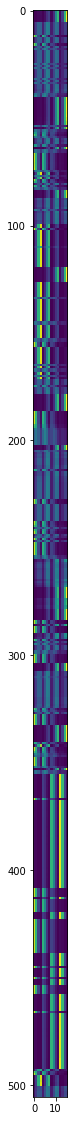

In [207]:
## for housing dataset
plt.figure(figsize=(10,20))
plt.imshow(S.layers[4])

In [208]:
# Chargement des données
""" A COMPLETER """
input_data = data.data
a , b = 8 , 8
# Création et apprentissage de la DeepSOM
""" A COMPLETER """
shape = (a,b)
nb_layers = 5
S = DeepSOM(input_data, nb_layers, shape)
sortie = S.train(100)

""" A COMPLETER """
l=0
for lay in S.layers:
    l+=1
    """ A COMPLETER """
    minmaxall = []
    for i in range(len(lay)):
        minmax = []
        for j in range(len(lay)):
                if i != j :
                    minmax.append(euclidean_distances([lay[i]], [lay[j]]).item() )  
        minmaxall.append(min(minmax) / max(minmax) )
    
    index = np.mean(minmaxall)
    print("Couche ",l,": score = ", round(index,3))


Couche  1 : score =  0.08
Couche  2 : score =  0.046
Couche  3 : score =  0.021
Couche  4 : score =  0.014
Couche  5 : score =  0.009


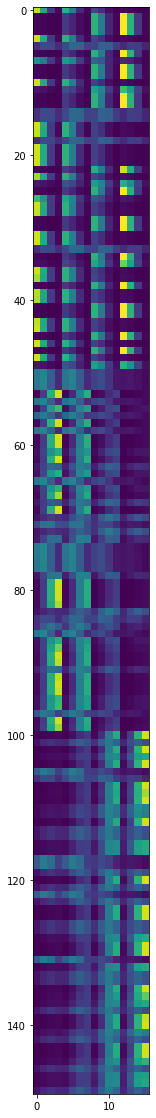

In [198]:
## for iris dataset
plt.figure(figsize=(10,20))
plt.imshow(S.layers[4])

In [199]:
from sklearn.datasets import load_boston

In [200]:
X, y = load_boston(return_X_y=True)